We should load the necessary libraries we will be using, including the `diversedata` package.

In [1]:
library(diversedata)
library(tidyverse)
library(AER)
library(broom)
library(knitr)
library(MASS)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


# 1 Data Cleaning & Processing

First, let's load our data (`womensmarchmadness` from `diversedata` package) and remove all NA values for our variables of interest `seed` and `tourney_wins`.

In [2]:
# Reading Data
marchmadness <- womensmarchmadness

# Review total rows
nrow(marchmadness)

[1] 2092

In [3]:
# Removing NA but only in selected columns
marchmadness <- marchmadness |> drop_na(seed, tourney_wins)

# Notice no rows were removed
nrow(marchmadness)

[1] 2092

Note that, the `seed = 0` designation in 1983 notes the eight teams that played an opening-round game to become the No.8 seed in each region. For this exercise, we will not take them into consideration. Since `seed` is an ordinal categorical variable, we can set it as an ordered factor.

In [4]:
marchmadness <- marchmadness |> 
  filter(seed != 0)

# 2 Exploratory Data Analysis

We can see which seeds appear more often.

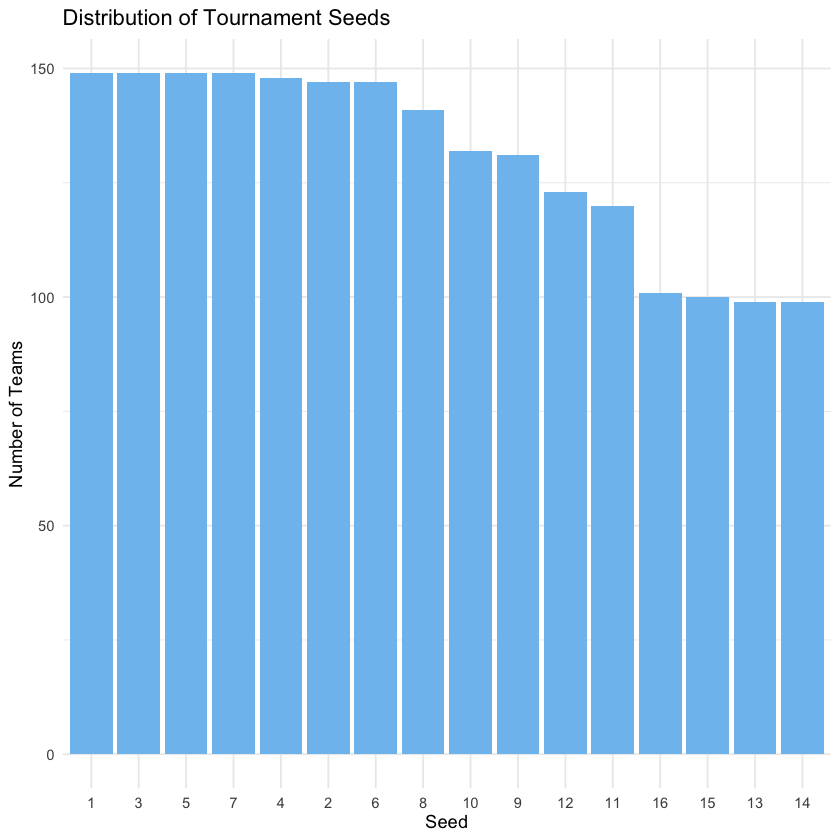

In [5]:
seed_count <- marchmadness |> 
  count(seed) |> 
  arrange(desc(n)) |>
  mutate(seed = factor(seed, levels = seed))

ggplot(
  seed_count, 
  aes(x = seed, y = n)
  ) +
  geom_col(fill = "skyblue2") +
  labs(
    title = "Distribution of Tournament Seeds",
    x = "Seed",
    y = "Number of Teams") +
  theme_minimal()

We can also take a look at the average tournament wins for each seed:

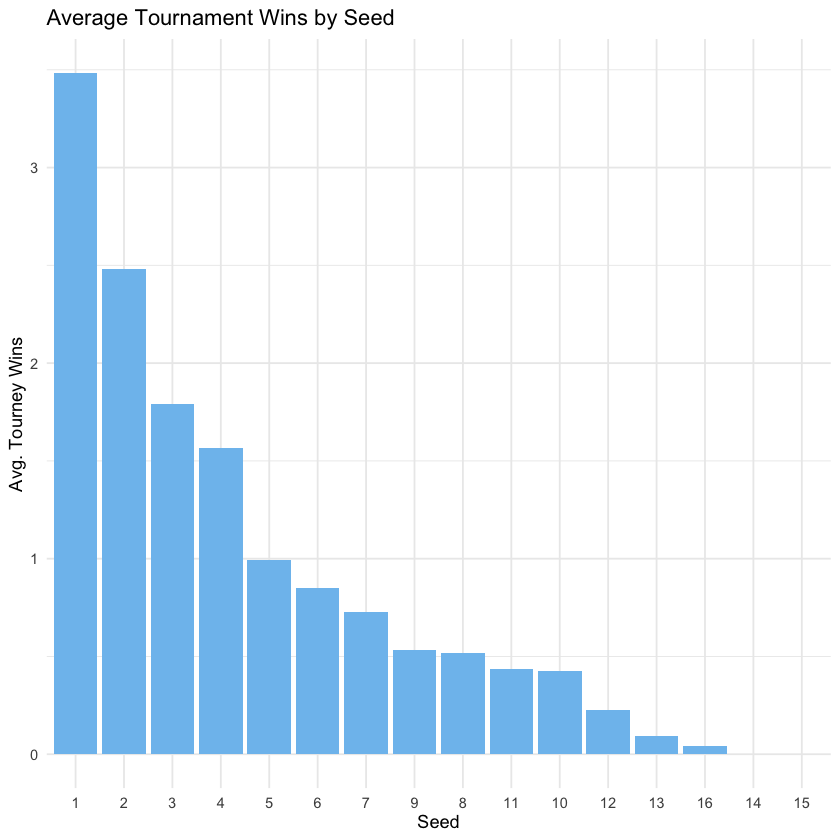

In [6]:
marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  group_by(seed) |> 
  summarise(
    avg_tourney_wins = mean(tourney_wins, na.rm = TRUE)
    ) |>
  arrange(desc(avg_tourney_wins)) |>
  mutate(seed = factor(seed, levels = seed)) |>
  ggplot(
    aes(
      x = as.factor(seed),
      y = avg_tourney_wins)
    ) +
  geom_col(fill = "skyblue2") +
  labs(
    title = "Average Tournament Wins by Seed",
    x = "Seed",
    y = "Avg. Tourney Wins"
  ) +
  theme_minimal()

We can note that a teams with a higher seed tend to win more tournaments! We can also see the total amount of tourney wins for each seed.

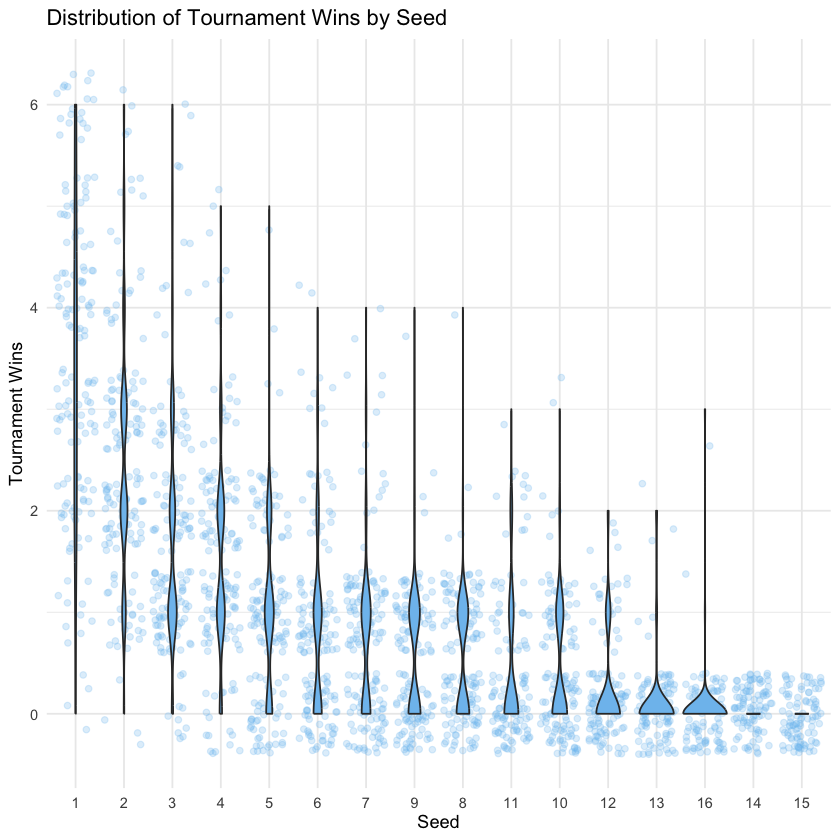

In [7]:
seed_order <- marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  group_by(seed) |> 
  summarise(avg_wins = mean(tourney_wins, na.rm = TRUE)) |> 
  arrange(desc(avg_wins)) |> 
  pull(seed)

marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  mutate(seed = factor(seed, levels = seed_order)) |> 
  ggplot(
    aes(x = seed, y = tourney_wins)
  ) +
  geom_jitter(alpha = 0.25, color = "skyblue2") +
  geom_violin(fill = "skyblue2") +
  labs(
    title = "Distribution of Tournament Wins by Seed",
    x = "Seed",
    y = "Tournament Wins"
  ) +
  theme_minimal()

# 3 Seed Treatment: Numeric vs Factor

An important decision on this analysis is whether to use `seed` as a numeric or an ordered categorical predictor. Treating `seed` as a numeric explanatory variable assumes that the effect of seed is linear on the log scaled of the amount of `tourney_wins`.

To test if this assumption is appropriate, we can compare models that make different assumptions about `seed`. We'll create models using `seed` as both a numeric variable and a factor.

However, first, we need to encode `seed` as an ordered factor.

In [8]:
marchmadness_factor <- marchmadness |> 
  mutate(seed = as.ordered(seed)) |> 
  mutate(seed = fct_relevel
         (seed, 
           c("1", "2", "3", "4", "5", 
             "6", "7", "8", "9", "10", 
             "11", "12", "13", "14", "15", 
             "16")))

Given that we're setting `tourney_wins` as a response, our linear regression model may output negative values at high seed values. Therefore, a Poisson Regression model is better suited, considering that tourney wins is a count variable and is always non-negative.

In [9]:
options(contrasts = c("contr.treatment", "contr.sdif"))

poisson_model <- glm(tourney_wins ~ seed, family = "poisson", data = marchmadness)

poisson_model_factor <- glm(tourney_wins ~ seed, family = "poisson", data = marchmadness_factor)

We can visualize how the two models fit the data to evaluate if treating `seed` as `numeric` or `factor` would have a significant impact on our modelling process.

`geom_smooth()` using formula = 'y ~ x'


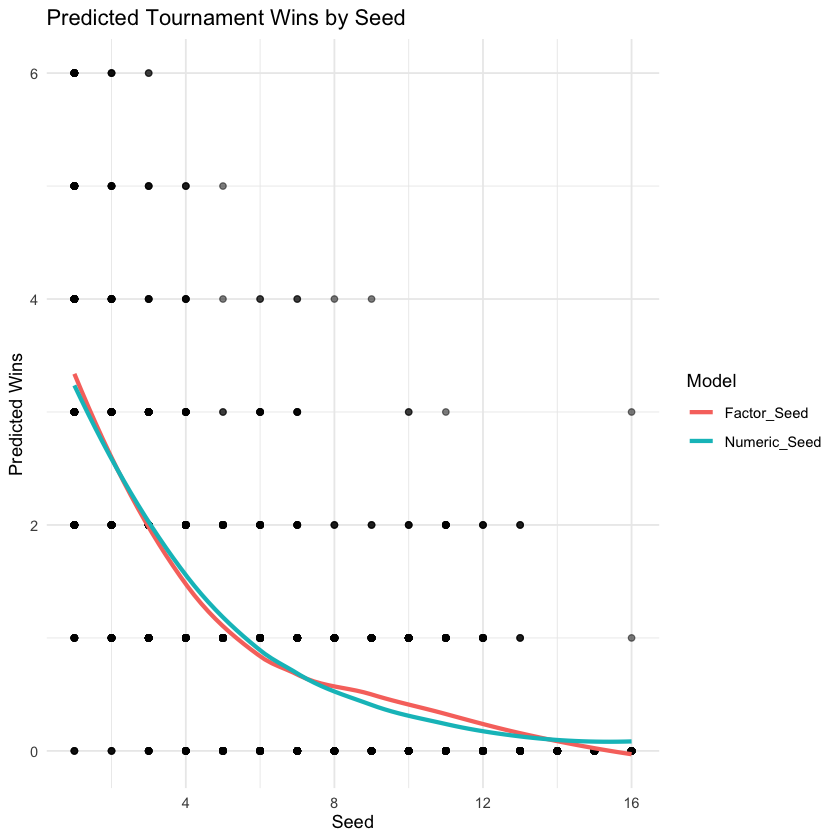

In [10]:
marchmadness <- marchmadness |> 
  mutate(
    Numeric_Seed = predict(poisson_model, type = "response"),
    Factor_Seed = predict(poisson_model_factor, type = "response")
  )

plot_data <- marchmadness |> 
  dplyr::select(seed, tourney_wins, Numeric_Seed, Factor_Seed) |> 
  pivot_longer(cols = c("Numeric_Seed","Factor_Seed"), names_to = "model", values_to = "predicted")

ggplot(plot_data, aes(x = seed, y = predicted, color = model)) +
  geom_point(aes(y = tourney_wins), alpha = 0.3, color = "black") +
  geom_line(stat = "smooth", method = "loess", se = FALSE, linewidth = 1.2) +
  labs(title = "Predicted Tournament Wins by Seed",
       x = "Seed",
       y = "Predicted Wins",
       color = "Model") +
  theme_minimal()

Visually, both models don't appear to be significantly different from each other. Now, if we wanted to formally evaluate which is the better approach we could use likelihood-based model selection tools.

In [11]:
kable(glance(poisson_model), digits = 2)



| null.deviance| df.null|   logLik|     AIC|     BIC| deviance| df.residual| nobs|
|-------------:|-------:|--------:|-------:|-------:|--------:|-----------:|----:|
|       3438.76|    2083| -2117.42| 4238.84| 4250.12|  1610.34|        2082| 2084|

In [12]:
kable(glance(poisson_model_factor), digits = 2)



| null.deviance| df.null|   logLik|     AIC|     BIC| deviance| df.residual| nobs|
|-------------:|-------:|--------:|-------:|-------:|--------:|-----------:|----:|
|       3438.76|    2083| -2079.52| 4191.04| 4281.31|  1534.54|        2068| 2084|

Based on lower residual deviance, higher log-likelihood, and a lower AIC, the model that treats `seed` as a factor fits the data better. This would suggest that the relationship between tournament seed and number of wins is **not linear**, and would support using an approach that does not assume a constant effect per unit change in seed.

However, before deciding on using a more complex model, we can evaluate if this complexity offers a significantly better modeling approach. To do this, we can perform a likelihood ratio test.

$H_0$: Model `poisson_model` fits the data better than model `poisson_model_factor`

$H_a$: Model `poisson_model_factor` fits the data better than model `poisson_model

In [13]:
anova_result <- tidy(anova(poisson_model, poisson_model_factor, test = "Chisq"))

kable(anova_result, digits = 2) 



|term                | df.residual| residual.deviance| df| deviance| p.value|
|:-------------------|-----------:|-----------------:|--:|--------:|-------:|
|tourney_wins ~ seed |        2082|           1610.34| NA|       NA|      NA|
|tourney_wins ~ seed |        2068|           1534.54| 14|    75.79|       0|

These results indicate strong evidence that the model with `seed` treated as a factor fits the data significantly better than treating it as a numeric predictor. Therefore, we will proceed by using `seed` as a factor.


# 4 Overdispersion Testing

It is noteworthy that Poisson assumes that the mean is equal to the variance of the count variable. If the variance is much greater, we might need a Negative Binomial model. We can do an dispersion test to evaluate this matter.

Letting $Y_i$ be the $ith$ Poisson response in the count regression model, in the presence of equidispersion, $Y_i$ has the following parameters:

$E(Y_i)=\lambda_i, Var(Y_i)=\lambda_i$

The test uses the following mathematical expression (using a $1+\gamma$ dispersion factor):

$Var(Y_i)=(1+\gamma)\times\lambda_i$

with the hypotheses:

$H_0:1 + \gamma = 1$

$H_a: 1 + \gamma > 1$

When there is evidence of overdispersion in our data, we will reject $H_0$.

In [14]:
kable(tidy(dispersiontest(poisson_model_factor)), digits = 2)



| estimate| statistic| p.value|method              |alternative |
|--------:|---------:|-------:|:-------------------|:-----------|
|     0.96|     -0.56|    0.71|Overdispersion test |greater     |

Since the P-value is much greater than 0.05, we fail to reject the null hypothesis. This suggests that there is no significant evidence of overdispersion in the Poisson model.

In [15]:
summary_model <- tidy(poisson_model_factor) |> 
  mutate(exp_estimate = exp(estimate)) |> 
  mutate_if(is.numeric, round, 3) |> 
  filter(p.value <= 0.05)
  
kable(summary_model, digits = 2)



|term      | estimate| std.error| statistic| p.value| exp_estimate|
|:---------|--------:|---------:|---------:|-------:|------------:|
|seed2-1   |    -0.34|      0.07|     -4.96|    0.00|         0.71|
|seed3-2   |    -0.33|      0.08|     -4.05|    0.00|         0.72|
|seed5-4   |    -0.46|      0.10|     -4.34|    0.00|         0.63|
|seed8-7   |    -0.34|      0.15|     -2.22|    0.03|         0.71|
|seed12-11 |    -0.64|      0.23|     -2.75|    0.01|         0.52|
|seed13-12 |    -0.92|      0.38|     -2.40|    0.02|         0.40|

Based on these results, we can see that `seed` is significantly associated with `tourney_wins`, particularly in changes in levels between lower seeds. These results can be interpreted as:

Seed 2 teams are expected to win 29% fewer games than Seed 1 teams

-   Seed 2 teams are expected to win 29% (1-0.71) fewer games than Seed 1 teams.

-   Seed 3 teams are expected to win 28% fewer games than Seed 2 teams.

-   Seed 5 teams are expected to win 37% fewer games than Seed 4 teams.

-   Seed 8 teams are expected to win 29% fewer games than Seed 7 teams.

-   Seed 12 teams are expected to win 48% fewer games than Seed 11 teams.

-   Seed 13 teams are expected to win 60% fewer games than Seed 12 teams.

This conclusion is easier to interpret visually, so, let's plot our Poisson regression model to view the impact of `seed` on `tourney_wins`:

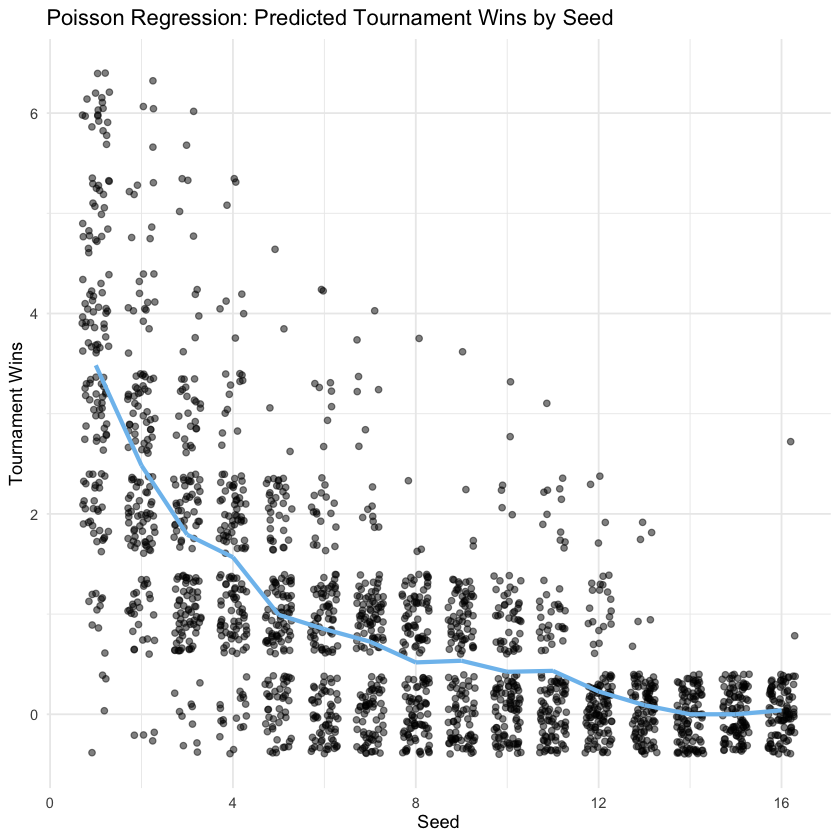

In [16]:
marchmadness$predicted_wins <- predict(poisson_model_factor, type = "response")

model_plot <- ggplot(marchmadness, aes(x = seed, y = tourney_wins)) +
  geom_jitter(width = 0.3, alpha = 0.5) +
  geom_line(aes(y = predicted_wins), color = "skyblue2", linewidth = 1.2) +
  labs(title = "Poisson Regression: Predicted Tournament Wins by Seed",
       x = "Seed",
       y = "Tournament Wins") +
  theme_minimal()

model_plot

# Discussion

This analysis examined the relationship between a team’s tournament seed and its performance in the NCAA Division 1 Women’s Basketball Tournament. The results suggest that:

1.  **Poisson regression supports seeding as a predictor**: The Poisson regression model indicates that seed is a significant predictor of tournament wins, suggesting that higher-ranked teams tend to win more, even between closely ranked seeds.

2.  **Proper variable coding is essential**: Treating seed as a numeric variable would assume a linear relationship on the log scale of expected tournament wins, meaning each one-unit increase in seed (e.g., from 1 to 2, or 10 to 11) would be associated with the same proportional decrease in wins. This oversimplifies the real pattern. By encoding seed as an ordered factor, the model can estimate distinct effects for each seed level, allowing for more accurate and nuanced interpretation.

3.  **There is a lot of variation around the prediction**: While seeding generally reflects team strength, upsets and unexpected performances do occur, showing that other factors also influence tournament outcomes.

Seeding is an important predictor of success, but clearly other factors influence the results. Unexpected performances are common in March Madness, so investigating additional variables could provide a fuller picture of what drives tournament outcomes.

# Attribution

Data sourced from FiveThirtyEight's NCAA Women's Basketball Tournament data set, available under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/). Original data set: [FiveThirtyEight GitHub Repository](https://github.com/fivethirtyeight/data/tree/master/ncaa-womens-basketball-tournament). Story: [Louisiana Tech Was the UConn of the '80s](https://fivethirtyeight.com/features/louisiana-tech-was-the-uconn-of-the-80s/).


Brooke-Marciniak, B. A. (2016, February 7). Here’s why women who play sports are more successful. [LinkedIn article](https://www.linkedin.com/pulse/heres-why-women-who-play-sports-more-successful-brooke-marciniak/).